In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect = True)


In [6]:
# View all of the classes that automap found
inspect = inspect(engine)
print(inspect.get_table_names())

['measurement', 'station']


In [7]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
col_name = inspect.get_columns('measurement')
for col in col_name:
    print(col['name'], col['type'])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
recent_date = engine.execute('select max(date) from measurement').fetchall()
print(f"The most recent date is {recent_date[0][0]}")

The most recent date is 2017-08-23


One year from most recent date was 2016-08-23 00:00:00


,Dates,Precipitation,Month/Year
0,2016-08-24,0.08,16-08
1,2016-08-25,0.08,16-08
2,2016-08-26,0.00,16-08
3,2016-08-27,0.00,16-08
4,2016-08-28,0.01,16-08
...,...,...,...
2216,2017-08-17,0.13,17-08
2218,2017-08-19,0.09,17-08
2220,2017-08-21,0.56,17-08
2221,2017-08-22,0.50,17-08


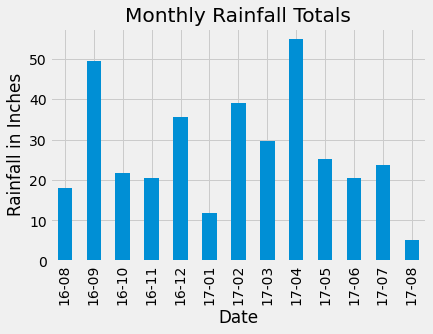

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
import datetime as dt
start_date = dt.datetime(2016,8,23)
print(f"One year from most recent date was {start_date}")

# Starting from the most recent data point in the database. 
# Perform a query to retrieve the data and precipitation scores
one_year = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= start_date).all()




# Save the query results as a Pandas DataFrame and set the index to the date column
raindex = [{'Dates':rain[0], "Precipitation":rain[1]} for rain in one_year]


raindex_df = pd.DataFrame(raindex)
raindex_df = raindex_df.dropna()

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data
raindex_df['Dates']=pd.to_datetime(raindex_df['Dates'])
raindex_df['Month/Year']=raindex_df['Dates'].apply(lambda x: x.strftime('%y-%m'))



raindex_df.groupby('Month/Year')['Precipitation'].sum().plot.bar()
plt.ylabel('Rainfall in Inches')
plt.xlabel('Date')
plt.title('Monthly Rainfall Totals')
raindex_df

# Use Pandas to calcualte the summary statistics for the precipitation data


In [24]:
raindex_df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
columns = inspect.get_columns('station')
for col in col_name:
    print(col['name'], col['type'])

stations = session.query(func.count(station.station)).all()
print(f"There are {stations[0][0]} stations")

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
There are 9 stations


In [39]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_count = session.query(measurement.station,func.count(measurement.prcp)).\
    group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

station_count
# List the stations and the counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2685),
 ('USC00513117', 2696),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [42]:
print(f"The station with the most recordings is {station_count[0][0]}")

The station with the most recordings is USC00519281


In [71]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temps = session.query(func.min(measurement.tobs),func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station==station_count[0][0]).all()
temps[0]
temp_avg = temps[0][2]
temp_min = temps[0][0]
temp_max = temps[0][1]


print(f"The avg temp at {station_count[0][0]} is {round(temp_avg, 2)} degrees F")
print(f"The min temp at {station_count[0][0]} is {temp_min} degrees F")
print(f"The max temp at {station_count[0][0]} is {temp_max} degrees F")


The avg temp at USC00519281 is 71.66 degrees F
The min temp at USC00519281 is 54.0 degrees F
The max temp at USC00519281 is 85.0 degrees F


In [73]:
# Using the most active station id
last_obs = session.query(func.max(measurement.date)).\
    filter(measurement.station==station_count[0][0]).all()
last_obs


[('2017-08-18')]

In [81]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
start_obs = dt.datetime(2016,8,18)
temp_obs = session.query(measurement.station, measurement.date, measurement.tobs).\
    filter(measurement.station==station_count[0][0], measurement.date>=start_obs).all()
temp_list = [{"Station":temps[0], "Date":temps[1], "Temp (F)":temps[2]}for temps in temp_obs]
temp_df = pd.DataFrame(temp_list)
temp_df

,Station,Date,Temp (F)
0,USC00519281,2016-08-19,79.0
1,USC00519281,2016-08-20,81.0
2,USC00519281,2016-08-21,79.0
3,USC00519281,2016-08-22,78.0
4,USC00519281,2016-08-23,77.0
...,...,...,...
351,USC00519281,2017-08-14,77.0
352,USC00519281,2017-08-15,77.0
353,USC00519281,2017-08-16,76.0
354,USC00519281,2017-08-17,76.0


Text(0.5, 1.0, 'Temps recorded at USC00519281')

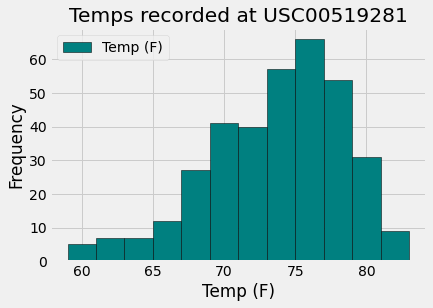

In [88]:
temp_df.plot.hist(bins=12, color= "teal", ec='black')
plt.xlabel('Temp (F)')
plt.title(f"Temps recorded at {station_count[0][0]}")

# Close session

In [89]:
# Close Session
session.close()